In [146]:
import os
import requests
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
SEED = 42
RNG = torch.Generator().manual_seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

Running on device: CUDA


In [147]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [148]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=True, download=False, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=False, download=False, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=1)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=1)

# download the forget and retain index split
local_path = "../example notebooks/forget_idx.npy"
# if not os.path.exists(local_path):
#     response = requests.get(
#         "https://storage.googleapis.com/unlearning-challenge/" + local_path
#     )
#     open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=False, num_workers=1
)
# retain_loader = torch.utils.data.DataLoader(
#     retain_set, batch_size=128, shuffle=True, num_workers=1, generator=RNG
# )

In [149]:
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=False, num_workers=1
)

In [150]:
local_path = "../example notebooks/weights/weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

In [151]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total

In [152]:
def unstructure_prune(model, pruning_amount=0.2, global_pruning=False, random_init=False):

    parameters_to_prune = []
    if global_pruning:
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
                parameters_to_prune.append((module, 'weight'))

        #Global pruning
        prune.global_unstructured(
            parameters_to_prune,
            pruning_method=prune.L1Unstructured,
            amount=pruning_amount
        )

    else:
         for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
                prune.l1_unstructured(module, name='weight', amount=pruning_amount)
                parameters_to_prune.append((module, 'weight'))
                

    # Randomly re-initialize pruned weights while preserving the mask
    for module, param_name in parameters_to_prune:
        if random_init:
            mask = getattr(module, f"{param_name}_mask")  # Get the binary mask used for pruning
            init_weights = getattr(module, param_name)  # Get the current weights
            # Randomly initialize new weights
            new_weights = torch.randn_like(init_weights)
            # Apply the pruning mask to keep the pruned weights zero
            new_weights = new_weights * mask
            # Assign the new weights
            setattr(module, param_name, torch.nn.Parameter(new_weights))
        # Make the pruning permanent by removing the mask
        prune.remove(module, param_name)

In [153]:
def plot_teacher_student_outputs(teacher_logits, student_logits):
    teacher_probs = torch.nn.functional.softmax(teacher_logits, dim=0).cpu().numpy()
    student_probs = torch.nn.functional.softmax(student_logits, dim=0).cpu().numpy()
    plt.plot(teacher_probs, 'ko', label='teacher')
    plt.plot(student_probs, 'ro', label='student')
    plt.legend()
    plt.yscale('log')
    plt.show()

In [154]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

In [155]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [156]:
def calc_mia_acc(forget_loss, test_loss):
    # make sure we have a balanced dataset for the MIA
    assert len(test_loss) == len(forget_loss)

    ft_samples_mia = np.concatenate((test_loss, forget_loss)).reshape((-1, 1))
    labels_mia = [0] * len(test_loss) + [1] * len(forget_loss)

    ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

    return ft_mia_scores.mean()

In [157]:
def get_all_metrics(model, student_model, retain_loader, forget_loader, val_loader, test_loader):

    model.eval()
    
    print(f"Retain set accuracy: {100.0 * accuracy(student_model, retain_loader):0.1f}%")
    print(f"Forget set accuracy: {100.0 * accuracy(student_model, forget_loader):0.1f}%")
    print(f"Val set accuracy: {100.0 * accuracy(student_model, val_loader):0.1f}%")
    print(f"Test set accuracy: {100.0 * accuracy(student_model, test_loader):0.1f}%")

    ft_forget_losses = compute_losses(student_model, forget_loader)
    ft_test_losses = compute_losses(model, test_loader)

    ft_mia_scores = calc_mia_acc(ft_forget_losses, ft_test_losses)

    print(
        f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
    )

    return ft_forget_losses, ft_test_losses, ft_mia_scores

In [158]:
print(f"Retain set accuracy: {100.0 * accuracy(model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(model, forget_loader):0.1f}%")
print(f"Val set accuracy: {100.0 * accuracy(model, val_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Retain set accuracy: 99.5%
Forget set accuracy: 99.3%
Val set accuracy: 88.9%
Test set accuracy: 88.3%


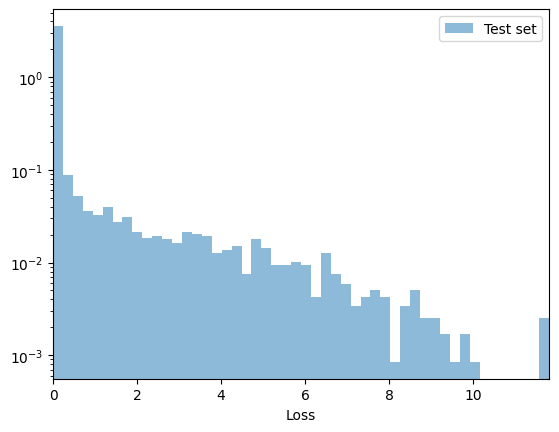

In [159]:
ft_test_losses = compute_losses(model, test_loader)
ft_val_losses = compute_losses(model, val_loader)
plt.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.xlabel("Loss")
plt.yscale("log")
plt.xlim((0, np.max(ft_test_losses)))
plt.legend()

plt.show()

## Teacher

In [160]:
'''
Shuffle retain data
'''

data_list = []
label_list = []

for data, label in retain_loader:
    data_list.append(data)
    label_list.append(label)
    
all_data = torch.cat(data_list, 0)
all_labels = torch.cat(label_list, 0)
    
combined = list(zip(all_data, all_labels))
random.shuffle(combined)
shuffled_data, shuffled_labels = zip(*combined)

shuffled_data = torch.stack(shuffled_data)
shuffled_labels = torch.stack(shuffled_labels)

shuffled_dataset = TensorDataset(shuffled_data, shuffled_labels)
retain_loader = DataLoader(shuffled_dataset, batch_size=128, shuffle=False)

In [161]:
teacher_logits_tensor = torch.zeros(len(retain_loader.dataset), 10)

start_idx = 0
with torch.no_grad():
    for (inputs, labels) in retain_loader:
        end_idx = start_idx + inputs.shape[0]
        outputs = model(inputs.to(DEVICE))
        teacher_logits_tensor[start_idx:end_idx] = outputs.cpu()
        start_idx = end_idx

# Create a dataloader
retain_logit_loader = DataLoader(teacher_logits_tensor, batch_size=128, shuffle=False)


teacher_logits_tensor = torch.zeros(len(forget_loader.dataset), 10)

start_idx = 0
with torch.no_grad():
    for (inputs, labels) in forget_loader:
        end_idx = start_idx + inputs.shape[0]
        outputs = model(inputs.to(DEVICE))
        teacher_logits_tensor[start_idx:end_idx] = outputs.cpu()
        start_idx = end_idx

# Create a dataloader
forget_logit_loader = DataLoader(teacher_logits_tensor, batch_size=128, shuffle=False)

## Student

In [162]:
student_model = resnet18(weights=None, num_classes=10)
student_model.load_state_dict(weights_pretrained)
student_model.to(DEVICE)

# Apply pruning
# pct = 0.5
# unstructure_prune(student_model, pct, global_pruning=False, random_init=True)

# pct = 0.50
# unstructure_prune(student_model, pct, global_pruning=False, random_init=True)

In [163]:
# student_logits = torch.zeros(len(retain_loader.dataset), 10)

# start_idx = 0
# with torch.no_grad():
#     for (inputs, labels) in retain_loader:
#         end_idx = start_idx + inputs.shape[0]
#         outputs = student_model(inputs.to(DEVICE))
#         student_logits[start_idx:end_idx] = outputs.cpu()
#         start_idx = end_idx

In [164]:
# plot_teacher_student_outputs(teacher_logits_tensor[3], student_logits[3])

## Knowledge distillation

In [165]:
def calculate_kl_loss(student_logits, teacher_logits, T=2.0, forget_T=2.0, forget_flag=False):
    
    teacher_logits = teacher_logits/T

    if forget_flag:
        teacher_logits = teacher_logits/forget_T
        teacher_logits = teacher_logits + 0.05*torch.rand(teacher_logits.shape).to(DEVICE)

    # Calculate soft labels from teacher
    teacher_probs = F.softmax(teacher_logits, dim=1)

    # Compute distillation loss
    student_log_probs = F.log_softmax(student_logits/T, dim=1)
    distillation_loss = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (T * T)

    return distillation_loss

In [166]:
# Function to update learning rate
def adjust_learning_rate(optimizer, current_batch, total_batches, initial_lr):
    """Sets the learning rate for warmup over total_batches"""
    lr = initial_lr * (current_batch / total_batches)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [167]:
alpha = 0.9
n_classes = 10
T = 2

In [176]:
initial_lr = 1e-4
total_samples = len(retain_loader.dataset)
batch_size = retain_loader.batch_size
batches_per_epoch  = math.ceil(total_samples / batch_size)
warmup_batches = math.ceil(0.2*batches_per_epoch)
warmup_current_batch = 0

epochs = 10
pct_of_retain_for_ft = 0.1 # Be aware of the % below
calc_val_acc_every = 0.02 # Pct of the retrain set
forget_KL_CE_ratio = 0.5
beta = 1 # Multiplier to CE for gradient ascent

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student_model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=0, min_lr=0, verbose=True)

In [177]:
student_model.train()

for ep in range(epochs):
    print(ep)
    print('***')

    # Initialize flag for depleted iterator
    depleted = False

    # Initialize iterators at the beginning of each epoch
    current_batch = 0
    best_val_acc = 100
    iter_retain = iter(retain_loader)
    iter_teacher_retain = iter(retain_logit_loader)


    ''' Retain fine-tuning '''

    while not depleted:

        try:
            batch = next(iter_retain)
            teacher_logits = next(iter_teacher_retain)
            
        except StopIteration:
            depleted = True
            print('depleted')
            break  # Skip to the next iteration

        # Only use a % of the retain set
        if torch.multinomial(torch.tensor([pct_of_retain_for_ft,1-pct_of_retain_for_ft], dtype=torch.float32), 1).item() > 0.5:
            continue

        inputs, targets = batch                
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        current_batch += 1
        warmup_current_batch += 1
        # Warm-up for the first 'warmup_batches' batches
        if warmup_current_batch <= warmup_batches:
            adjust_learning_rate(optimizer, warmup_current_batch, warmup_batches, initial_lr)

        optimizer.zero_grad()
        
        # Forward pass student
        student_logits = student_model(inputs)

        # Calculate soft labels from teacher
        teacher_probs = F.softmax(teacher_logits/T, dim=1)

        # Compute distillation loss
        student_log_probs = F.log_softmax(student_logits/T, dim=1).to('cpu')
        distillation_loss = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (T * T)

        # Compute the classification loss
        criterion = nn.CrossEntropyLoss()
        classification_loss = criterion(student_logits, targets)
        loss = alpha*distillation_loss + (1-alpha)*classification_loss
        loss.backward()
        optimizer.step()

        # if current_batch%(math.ceil(calc_val_acc_every*batches_per_epoch)-1)==0:

        #     with torch.no_grad():
        #         student_model.eval()

        #         val_acc = accuracy(student_model, val_loader)
        #         print(f"Val set accuracy: {100.0 * val_acc:0.2f}%")

        #         ft_forget_losses = compute_losses(student_model, forget_loader)
        #         ft_mia_scores = calc_mia_acc(ft_forget_losses, ft_val_losses)
        #         print(f"MIA accuracy: {100.0 * ft_mia_scores:0.2f}%")

        #         total_acc = val_acc*np.abs(ft_mia_scores - 0.5)
        #         print(f"Total accuracy: {100.0 * total_acc:0.2f}%")

        #         if total_acc > best_val_acc:
        #             # Restore model to previous checkpoint
        #             print('Restoring')
        #             checkpoint = torch.load(f'./checkpoints/temp_checkpoint.pth')
        #             student_model.load_state_dict(checkpoint['model'])
        #             optimizer.load_state_dict(checkpoint['optimizer'])
        #             # pct = 0.15
        #             # unstructure_prune(student_model, pct, global_pruning=False, random_init=False)
        #             break
        #         else:
        #             best_val_acc = total_acc
        #             # Save checkpoint
        #             print('Saving')
        #             torch.save({
        #                 'optimizer': optimizer.state_dict(),
        #                 'model': student_model.state_dict(),
        #             }, f'./checkpoints/temp_checkpoint.pth')
        #     student_model.train()


    ''' Forget fine-tuning '''

    if ep!= epochs-1:

        student_model.train()
        forget_batches = len(forget_loader.dataset)
        forget_counter = 1

        for sample in forget_loader:

            inputs, targets = sample
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            warmup_current_batch += 1
            forget_counter+=1

            # Warm-up for the first 'warmup_batches' batches
            if warmup_current_batch <= warmup_batches:
                adjust_learning_rate(optimizer, warmup_current_batch, warmup_batches, initial_lr)

            optimizer.zero_grad()

            # Forward pass student
            student_logits = student_model(inputs)

            # Calculate losses
            # distillation_loss = calculate_kl_loss(student_logits, teacher_logits, T=T, forget_T=2.0, forget_flag=False)
            criterion = nn.CrossEntropyLoss()
            classification_loss = criterion(student_logits, targets)

            # if torch.multinomial(torch.tensor([forget_KL_CE_ratio,1-forget_KL_CE_ratio], dtype=torch.float32), 1).item() < 0.5:
            # loss = -beta*distillation_loss
            # else:
            loss = -beta*classification_loss

            loss.backward()
            optimizer.step()

    #         if forget_counter%math.ceil(0.3*forget_batches/batch_size)==0:
    #             with torch.no_grad():
    #                 student_model.eval()
    #                 val_acc = accuracy(student_model, val_loader)
    #                 if val_acc > 0.15:
    #                     torch.save({
    #                         'optimizer': optimizer.state_dict(),
    #                         'model': student_model.state_dict(),
    #                     }, f'./checkpoints/temp_checkpoint.pth')
    #                     print(val_acc)
                        
    #                 else:
    #                     checkpoint = torch.load(f'./checkpoints/temp_checkpoint.pth')
    #                     student_model.load_state_dict(checkpoint['model'])
    #                     optimizer.load_state_dict(checkpoint['optimizer'])
    #                     print('restoring')
    #                     print(accuracy(student_model, val_loader))
    #                     break

    # if ep!= epochs-1:

    #     for (inputs, targets), teacher_logits in zip(forget_loader, forget_logit_loader):
    #         inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

    #         optimizer.zero_grad()
            
    #         # Forward pass student
    #         student_logits = student_model(inputs)

    #         # Calculate soft labels from teacher
    #         teacher_probs = F.softmax(teacher_logits/T/2.0  + 0.05*torch.rand(teacher_logits.shape), dim=1)

    #         # Compute distillation loss
    #         student_log_probs = F.log_softmax(student_logits/T, dim=1).to('cpu')
    #         distillation_loss = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (T * T)

    #         # Compute the classification loss
    #         criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    #         classification_loss = criterion(student_logits, targets)

    #         if torch.multinomial(torch.tensor([1-forget_KL_CE_ratio,forget_KL_CE_ratio], dtype=torch.float32), 1).item() < 0.5:
    #             loss = distillation_loss # - 0.9 * classification_loss
    #         else:
    #             loss = -beta*classification_loss
    #         loss.backward()
    #         optimizer.step()

    val_acc = accuracy(student_model, val_loader)
        # if val_acc < 0.15:
        #     checkpoint = torch.load(f'./checkpoints/temp_checkpoint.pth')
        #     student_model.load_state_dict(checkpoint['model'])
        #     optimizer.load_state_dict(checkpoint['optimizer'])
        #     print('restoring')
    print(f"Val set accuracy: {100.0 * val_acc:0.2f}%")

        # ft_forget_losses = compute_losses(student_model, forget_loader)
        # ft_mia_scores = calc_mia_acc(ft_forget_losses, ft_val_losses)
        # print(f"MIA accuracy: {100.0 * ft_mia_scores:0.2f}%")

        # total_acc = val_acc*np.abs(ft_mia_scores - 0.5)
        # print(f"Total accuracy: {100.0 * total_acc:0.2f}%")
        # print('--'*5)

    scheduler.step(val_acc)

0
***
depleted
Val set accuracy: 85.54%
1
***
depleted
Val set accuracy: 85.50%
Epoch 00002: reducing learning rate of group 0 to 5.0000e-05.
2
***
depleted
Val set accuracy: 85.48%
Epoch 00003: reducing learning rate of group 0 to 2.5000e-05.
3
***
depleted
Val set accuracy: 85.50%
Epoch 00004: reducing learning rate of group 0 to 1.2500e-05.
4
***
depleted
Val set accuracy: 85.52%
Epoch 00005: reducing learning rate of group 0 to 6.2500e-06.
5
***
depleted
Val set accuracy: 85.50%
Epoch 00006: reducing learning rate of group 0 to 3.1250e-06.
6
***
depleted
Val set accuracy: 85.50%
Epoch 00007: reducing learning rate of group 0 to 1.5625e-06.
7
***
depleted
Val set accuracy: 85.50%
Epoch 00008: reducing learning rate of group 0 to 7.8125e-07.
8
***
depleted
Val set accuracy: 85.52%
Epoch 00009: reducing learning rate of group 0 to 3.9063e-07.
9
***
depleted
Val set accuracy: 85.50%
Epoch 00010: reducing learning rate of group 0 to 1.9531e-07.


In [183]:
if (epochs<15) & (ep>5):
    print('a')

a


In [182]:
ep

9

In [170]:
ft_forget_losses, ft_test_losses, ft_mia_scores = get_all_metrics(model, student_model, retain_loader, forget_loader, val_loader, test_loader)

Retain set accuracy: 97.6%
Forget set accuracy: 94.0%
Val set accuracy: 85.8%
Test set accuracy: 86.2%
The MIA has an accuracy of 0.537 on forgotten vs unseen images


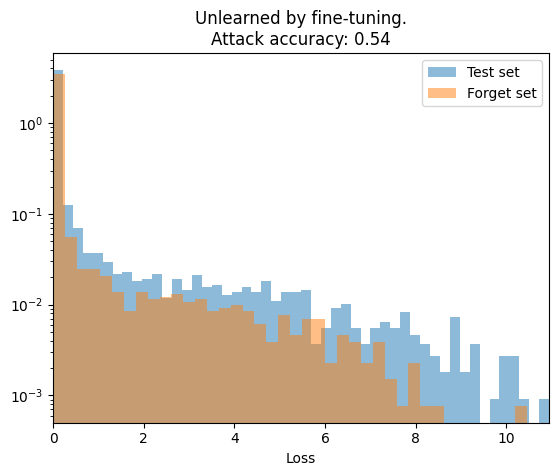

In [171]:
fig = plt.Figure(figsize=(16, 6))

plt.title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
plt.hist(ft_val_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

plt.xlabel("Loss")
plt.yscale("log")
plt.xlim((0, np.max(ft_val_losses)))
plt.legend()

plt.show()

In [172]:
student_logits = torch.zeros(len(retain_loader.dataset), 10)

start_idx = 0
with torch.no_grad():
    for (inputs, labels) in retain_loader:
        end_idx = start_idx + inputs.shape[0]
        outputs = student_model(inputs.to(DEVICE))
        student_logits[start_idx:end_idx] = outputs.cpu()
        start_idx = end_idx

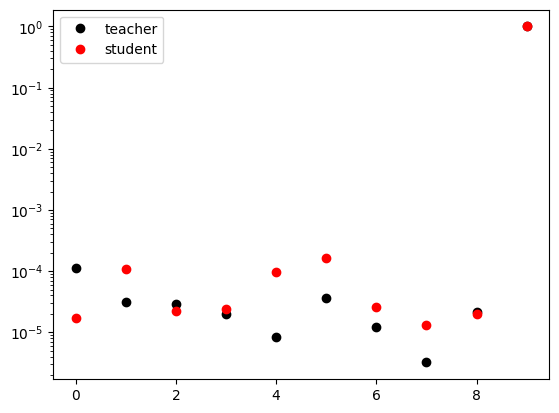

In [173]:
plot_teacher_student_outputs(teacher_logits_tensor[10], student_logits[10])